# EDA

Изучение, подготовка и сохранение данных для последующей работы

In [1]:
from time import perf_counter
from itertools import chain

In [2]:
import numpy as np
from scipy.stats import mvsdist, sem
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik

In [3]:
from sklearn.base import TransformerMixin
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from catboost import CatBoostClassifier

In [4]:
from utils import RANDOM_SEED, TEST_SIZE, TARGET_FEATURE, FIG_SIZES, DFS_NAME, TEST_DATA, TRAIN_DATA, SCORER
from utils import read, write, split, score, test_bt

In [5]:
BASELINE_CV = 10
BASELINE_TEST = False
TRAIN_SIZE_TEST = True
ONLY_PREPARE_DATA = False

In [6]:
df10, df20 = pd.read_csv(TRAIN_DATA), pd.read_csv(TEST_DATA)

# split to test and train
df1, dfs = df10.copy(), []
for i in range(len(TEST_SIZE)):
    test_size = TEST_SIZE[i] / (1 - sum(TEST_SIZE[:i]))
    df1, df2 = train_test_split(df1, test_size=test_size, random_state=RANDOM_SEED, stratify=df1[TARGET_FEATURE])
    dfs.append(df2)
dfs.append(df1)
dfs = [pd.concat([df10, df20])] + dfs[::-1] + [df20]

# check sizes
print(*[df.shape[0] for df in dfs], sep='/')

100000/25000/45000/30000


In [7]:
dfs[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           100000 non-null  int64  
 1   age          100000 non-null  int64  
 2   gender       100000 non-null  int64  
 3   height       100000 non-null  int64  
 4   weight       100000 non-null  float64
 5   ap_hi        100000 non-null  int64  
 6   ap_lo        100000 non-null  int64  
 7   cholesterol  100000 non-null  int64  
 8   gluc         100000 non-null  int64  
 9   smoke        100000 non-null  int64  
 10  alco         100000 non-null  int64  
 11  active       100000 non-null  int64  
 12  cardio       70000 non-null   float64
dtypes: float64(2), int64(11)
memory usage: 10.7 MB


In [8]:
# tools for test baseline model
results = pd.DataFrame()
def baseline(name, df, results=results):
    if ONLY_PREPARE_DATA or not BASELINE_TEST:
        return
    start = perf_counter()
    model = CatBoostClassifier(verbose=0, random_state=RANDOM_SEED, cat_features=list(df.select_dtypes(include='category').columns))
    res = cross_val_score(model, *split(df), scoring=SCORER, cv=BASELINE_CV)
    results.at[name, 'mean'] = np.mean(res)
    results.at[name, 'sem'] = sem(res)
    if results.shape[0] > 1:
        results.at[name, 'delta'] = results.at[name, 'mean'] - results.iloc[-2, 0]
    display(results)
    time = perf_counter() - start
    print(f"time spended for basline model evaluation: {int(time // 60)} m {int(time % 60)} s")

In [9]:
# set id
dfs = [df.set_index('id') for df in dfs]
baseline('base', dfs[1])

In [10]:
# funs for check all columns
def get_df_for_check(dfs):
    dfi = dfs[0].copy()
    dfi[TARGET_FEATURE] = dfi[TARGET_FEATURE].fillna(-1)
    return dfi

def splitter(series):
    return series.nunique() < 10

def describer(col, df):
    def temp(target_feature_val, df=df):
        df = df[df[TARGET_FEATURE] == target_feature_val][col]
        df = df.describe().to_frame().T
        df.index = [target_feature_val]
        return df
    return pd.concat([temp(x) for x in df[TARGET_FEATURE].unique()])

def value_counter(col, df):
    def temp(target_feature_val, df=df):
        dfn = df[df[TARGET_FEATURE] == target_feature_val][col]
        dfk = dfn.value_counts().to_frame().T
        dfk = pd.concat([dfk / df.shape[0], dfk / dfn.shape[0]], axis=1, keys=['full', 'self'])
        dfk.index = [target_feature_val]
        return dfk
    return pd.concat([temp(x) for x in df[TARGET_FEATURE].unique()])

def check_col(col, dfs=dfs):
    df = get_df_for_check(dfs)
    if splitter(df[col]):
        display(value_counter(col, df))
    else:
        fig, ax = plt.subplots(figsize=FIG_SIZES['small'])
        ax.set_title(col)
        sns.histplot(data=df, x=col, hue=TARGET_FEATURE, fill=False, element='step')
        plt.show()
        display(describer(col, df))

In [11]:
def iterate_over_dfs(fun, dfs=dfs):
    for i in range(len(dfs)):
        dfs[i] = fun(dfs[i])
    return dfs

def col_to_cat(col):
    def temp(df):
        df[col] = df[col].astype('category')
        return df
    return iterate_over_dfs(temp)

def delete_outliers_from_train(col, type_, dfs=dfs):
    if type_ == 'max':
        to_drop = dfs[1][dfs[1][col] > dfs[-1][col].max()].index
    elif type_ == 'min':
        to_drop = dfs[1][dfs[1][col] > dfs[-1][col].min()].index
    else:
        raise ValueError("type must be one of ['max', 'min']")
    dfs[0] = dfs[0].drop(index=to_drop)
    dfs[1] = dfs[1].drop(index=to_drop)
    return dfs

def replace_values_between_edges_by_fun(col, edges, fun, dfs=dfs):
    val = fun(dfs[0][col])
    for i in range(len(dfs)):
        dfs[i][col] = dfs[i][col].where((dfs[i][col] > edges[0]) & (dfs[i][col] < edges[1]), val)
    return dfs

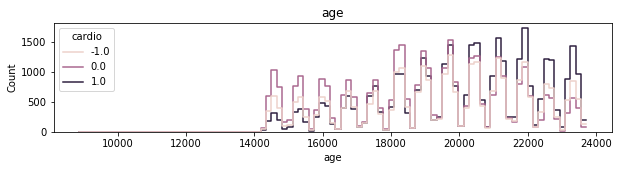

,count,mean,std,min,25%,50%,75%,max
0.0,35021.0,18881.623711,2473.925337,10798.0,16838.0,19005.0,20886.0,23678.0
1.0,34979.0,20056.813031,2315.927546,14275.0,18387.0,20384.0,21899.0,23713.0
-1.0,30000.0,19455.528400,2477.840922,8865.0,17658.0,19694.0,21320.0,23705.0


In [12]:
check_col('age')

In [13]:
check_col('gender')
col_to_cat('gender');
baseline('gender_to_cat', dfs[1])

full               self          
            1        2         1         2
 0.0  0.22914  0.12107  0.654293  0.345707
 1.0  0.22616  0.12363  0.646559  0.353441
-1.0  0.19388  0.10612  0.646267  0.353733

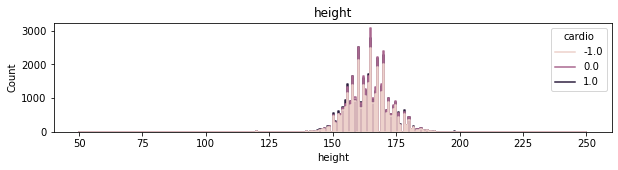

,count,mean,std,min,25%,50%,75%,max
0.0,35021.0,164.448017,8.148950,59.0,159.0,165.0,170.0,207.0
1.0,34979.0,164.270334,8.270084,55.0,159.0,165.0,170.0,250.0
-1.0,30000.0,164.322267,8.213740,50.0,159.0,165.0,170.0,198.0


In [14]:
check_col('height')
# delete_outliers_from_train('height', 'max');
# replace_values_between_edges_by_fun('height', (140, 200), lambda x: 140);
# check_col('height')
baseline('process_height_outliers', dfs[1])

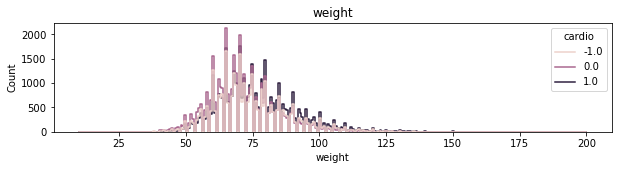

,count,mean,std,min,25%,50%,75%,max
0.0,35021.0,71.592150,13.305122,22.0,63.0,70.0,79.0,200.0
1.0,34979.0,76.822368,14.960125,10.0,66.0,75.0,85.0,200.0
-1.0,30000.0,74.120615,14.341540,10.0,65.0,72.0,82.0,183.0


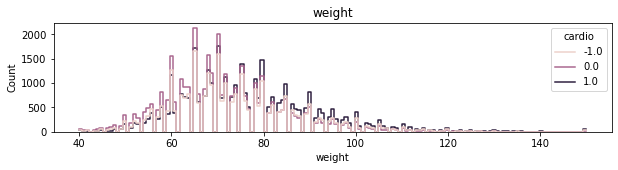

,count,mean,std,min,25%,50%,75%,max
0.0,35021.0,71.585906,13.228110,40.0,63.0,70.0,79.0,150.0
1.0,34979.0,76.807484,14.844633,40.0,66.0,75.0,85.0,150.0
-1.0,30000.0,74.114433,14.244670,40.0,65.0,72.0,82.0,150.0


In [15]:
check_col('weight')
delete_outliers_from_train('weight', 'max')
replace_values_between_edges_by_fun('weight', (40, 1000), lambda x: 40);
replace_values_between_edges_by_fun('weight', (0, 150), lambda x: 150);

def temp(df):
    df['weight'] = df['weight'].astype(int)
    return df

iterate_over_dfs(temp);
check_col('weight')
baseline('process_weight_outliers', dfs[1])

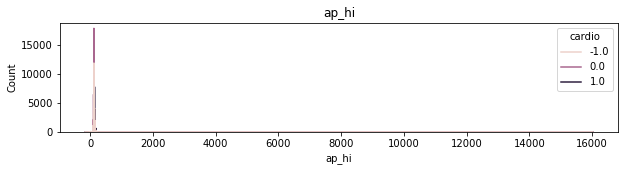

,count,mean,std,min,25%,50%,75%,max
0.0,35021.0,120.432598,103.550672,-120.0,110.0,120.0,120.0,14020.0
1.0,34979.0,137.212042,191.289607,-150.0,120.0,130.0,140.0,16020.0
-1.0,30000.0,130.271300,212.501152,-130.0,120.0,120.0,140.0,16020.0


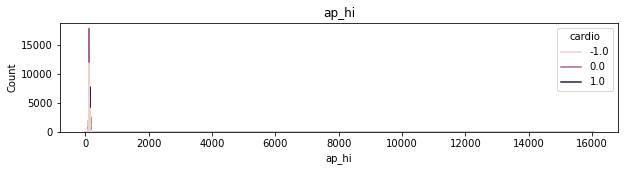

,count,mean,std,min,25%,50%,75%,max
0.0,35021.0,120.457440,103.521771,1.0,110.0,120.0,120.0,14020.0
1.0,34979.0,137.235484,191.272789,1.0,120.0,130.0,140.0,16020.0
-1.0,30000.0,130.280767,212.495348,1.0,120.0,120.0,140.0,16020.0


In [16]:
col = 'ap_hi'
check_col(col)

for i in range(len(dfs)):
    dfs[i][col] = dfs[i][col].where(dfs[i][col] > 0, -dfs[i][col])

edges = (80, 250, 800)    

# useless outliers deletion!
# for i in range(len(dfs)):
#     while any(dfs[i][col] > edges[-1]):
#         dfs[i][col] = dfs[i][col].where(dfs[i][col] < edges[-1], dfs[i][col] // 10)

# for i in range(len(dfs)):
#     while any(dfs[i][dfs[i][col] != 0][col] < edges[0]):
#         dfs[i][col] = dfs[i][col].where(dfs[i][col] > edges[0], dfs[i][col] * 10)

# for i in range(len(dfs)):
#     dfs[i][col] = dfs[i][col].where((dfs[i][col] > edges[0]) & (dfs[i][col] < edges[1]), dfs[i][col].mean())

check_col(col)
baseline('process_ap_hi_outliers', dfs[1])

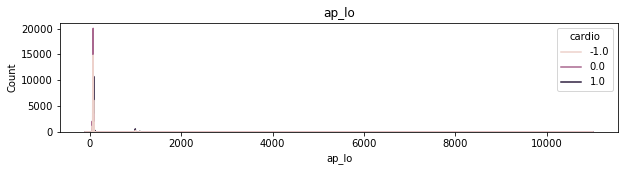

,count,mean,std,min,25%,50%,75%,max
0.0,35021.0,84.251763,152.686959,0.0,70.0,80.0,80.0,9800.0
1.0,34979.0,109.023929,217.805266,-70.0,80.0,80.0,90.0,11000.0
-1.0,30000.0,95.689000,163.852598,-90.0,80.0,80.0,90.0,9100.0


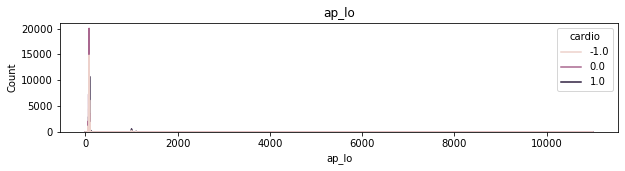

,count,mean,std,min,25%,50%,75%,max
0.0,35021.0,84.251763,152.686959,0.0,70.0,80.0,80.0,9800.0
1.0,34979.0,109.027931,217.803263,0.0,80.0,80.0,90.0,11000.0
-1.0,30000.0,95.695000,163.849094,0.0,80.0,80.0,90.0,9100.0


In [17]:
col = 'ap_lo'
check_col(col)

for i in range(len(dfs)):
    dfs[i][col] = dfs[i][col].where(dfs[i][col] > 0, -dfs[i][col])

edges = (50, 120, 500)    

# useless outliers deletion!
# for i in range(len(dfs)):
#     while any(dfs[i][col] > edges[-1]):
#         dfs[i][col] = dfs[i][col].where(dfs[i][col] < edges[-1], dfs[i][col] // 10)

# for i in range(len(dfs)):
#     while any(dfs[i][dfs[i][col] != 0][col] < edges[0]):
#         dfs[i][col] = dfs[i][col].where(dfs[i][col] > edges[0], dfs[i][col] * 10)

# for i in range(len(dfs)):
#     dfs[i][col] = dfs[i][col].where((dfs[i][col] > edges[0]) & (dfs[i][col] < edges[1]), dfs[i][col].mean())

check_col(col)
baseline('process_ap_lo_outliers', dfs[1])

In [18]:
def temp(df):
    df['ap_hi'] = (df['ap_hi'] // 5).astype(int).astype('category')
    df['ap_lo'] = (df['ap_lo'] // 5).astype(int).astype('category')
    return df

iterate_over_dfs(temp, dfs=dfs);
baseline('ap_to_cat', dfs[1])

In [19]:
check_col('cholesterol')
col_to_cat('cholesterol');
baseline('cholesterol_to_cat', dfs[1])

full                        self                    
            1        2        3         1         2         3
 0.0  0.29330  0.03799  0.01892  0.837498  0.108478  0.054025
 1.0  0.23055  0.05750  0.06174  0.659110  0.164384  0.176506
-1.0  0.22389  0.04181  0.03430  0.746300  0.139367  0.114333

In [20]:
check_col('gluc')
col_to_cat('gluc');
baseline('gluc_to_cat', dfs[1])

full                        self                    
            1        2        3         1         2         3
 0.0  0.30894  0.02112  0.02015  0.882156  0.060307  0.057537
 1.0  0.28585  0.03078  0.03316  0.817205  0.087996  0.094800
-1.0  0.25536  0.02247  0.02217  0.851200  0.074900  0.073900

In [21]:
check_col('smoke')
col_to_cat('smoke');
baseline('smoke_to_cat', dfs[1])

full               self          
            0        1         0         1
 0.0  0.31781  0.03240  0.907484  0.092516
 1.0  0.32050  0.02929  0.916264  0.083736
-1.0  0.27342  0.02658  0.911400  0.088600

In [22]:
check_col('alco')
col_to_cat('alco');
baseline('alco_to_cat', dfs[1])

full               self          
            0        1         0         1
 0.0  0.33080  0.01941  0.944576  0.055424
 1.0  0.33156  0.01823  0.947883  0.052117
-1.0  0.28350  0.01650  0.945000  0.055000

In [23]:
check_col('active')
col_to_cat('active');
baseline('active_to_cat', dfs[1])

full               self          
            1        0         1         0
 0.0  0.28643  0.06378  0.817881  0.182119
 1.0  0.27618  0.07361  0.789559  0.210441
-1.0  0.24172  0.05828  0.805733  0.194267

In [24]:
# new features
def temp(df):
    for col in [x for x in df.select_dtypes(np.number).columns if x != TARGET_FEATURE]:
        df[f'1frac{col}'] = 1 / df[col]
        if any(np.isinf(df[f'1frac{col}'])):
            raise ValueError
    # df['imt'] = df['weight'] / df['height'] ** 2
    # df['active_alco_smoke'] = pd.concat([df[col].astype(bool) for col in ['alco', 'smoke', 'active']], axis=1).all(axis=1).astype(int).astype('category')
    # df['age2'] = 2 ** (1 + (df['age'] - df['age'].min()) / (df['age'].max() - df['age'].min()))
    df['imt'] = df['weight'] / ((df['height'] / 100) ** 2)
    return df

iterate_over_dfs(temp, dfs);
baseline('add_new_features', dfs[1])

In [25]:
class MyPolynomialFeatures(TransformerMixin):
    def fit(self, *args):
        return self
    
    def transform(self, x, y=None):
        df = x.drop(columns=[TARGET_FEATURE]) if TARGET_FEATURE in x.columns else x.copy()
        f_num = df.select_dtypes(include=[np.number])
        f_not_num = df.select_dtypes(exclude=[np.number])
        pf = PolynomialFeatures(degree=2, include_bias=False)
        f_nums = pf.fit_transform(f_num)
        f_nums = pd.DataFrame(f_nums, index=f_num.index,
                              columns=pf.get_feature_names_out(f_num.columns))
        return pd.concat([f_nums, f_not_num] + ([x[TARGET_FEATURE]] if TARGET_FEATURE in x.columns else []), axis=1)

class MyMinMaxScaler(TransformerMixin):
    def fit(self, df, *args):
        self.coeffs = dict()
        ncat_cols = [x for x in df.select_dtypes(exclude='category').columns if x != TARGET_FEATURE]
        for col in ncat_cols:
            self.coeffs[col] = (df[col].quantile(0.01), df[col].quantile(0.99))
        return self
    
    def transform(self, df, *args):
        for col, (a, b) in self.coeffs.items():
            df[col] = (df[col] - a) / (b - a) * 2 - 1
        return df

In [26]:
# transformers = [MyMinMaxScaler(), MyPolynomialFeatures()]
transformers = [MyMinMaxScaler()]
for t in transformers:
    t.fit(dfs[1])
    
    def temp(df):
        return t.transform(df)
    
    iterate_over_dfs(temp, dfs);
    baseline(f'transformer_{t}', dfs[1])
    # baseline(f'transformer_{t}', temp(dfs[1]))

In [27]:
if not ONLY_PREPARE_DATA and BASELINE_TEST:
    results.sort_values('delta')

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, Wall time: 44min 1s


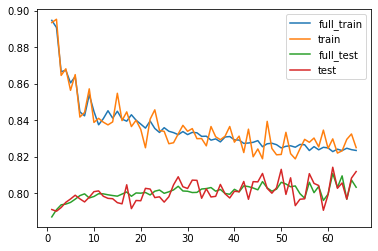

In [28]:
%%time
if not ONLY_PREPARE_DATA or TRAIN_SIZE_TEST:
    # look for optimal train size
    df = dfs[0].dropna(subset=TARGET_FEATURE)
    res = pd.DataFrame()
    # for n in chain(range(1, 11), range(11, 20, 3), range(20, 67, 6)):
    for n in chain(range(1, 11), range(11, 20, 1), range(20, 67, 1)):
        print(n, end=', ')
        df0 = df.sample(n * 1000)
        f, t = split(df0)
        model = CatBoostClassifier(verbose=0, random_state=RANDOM_SEED, cat_features=list(f.select_dtypes(include='category').columns))
        model.fit(f, t)
        res.at[n, 'full_train'] = score(model, df0)
        res.at[n, 'train'] = np.mean(test_bt(model, df0, 300, 20))
        res.at[n, 'full_test'] = score(model, df.drop(index=df0.index))
        r = test_bt(model, df.drop(index=df0.index), 500, 20)
        res.at[n, 'test'] = np.mean(r)
        # res.at[n, 'test1'] = np.mean(r) - sem(r)
        # res.at[n, 'test2'] = np.mean(r) + sem(r)
    res.plot()

In [29]:
write(DFS_NAME, dfs)